## **Data Wrangling**

In [13]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


=== Dataset Shape ===
(626, 8)

=== Data Types ===
state           object
numcol         float64
yieldpercol      int64
totalprod      float64
stocks         float64
priceperlb     float64
prodvalue      float64
year             int64
dtype: object

=== Missing Values ===
state          0
numcol         0
yieldpercol    0
totalprod      0
stocks         0
priceperlb     0
prodvalue      0
year           0
dtype: int64

=== Descriptive Statistics ===
              numcol  yieldpercol     totalprod        stocks  priceperlb  \
count     626.000000   626.000000  6.260000e+02  6.260000e+02  626.000000   
mean    60284.345048    62.009585  4.169086e+06  1.318859e+06    1.409569   
std     91077.087231    19.458754  6.883847e+06  2.272964e+06    0.638599   
min      2000.000000    19.000000  8.400000e+04  8.000000e+03    0.490000   
25%      9000.000000    48.000000  4.750000e+05  1.430000e+05    0.932500   
50%     26000.000000    60.000000  1.533000e+06  4.395000e+05    1.360000   
75%    

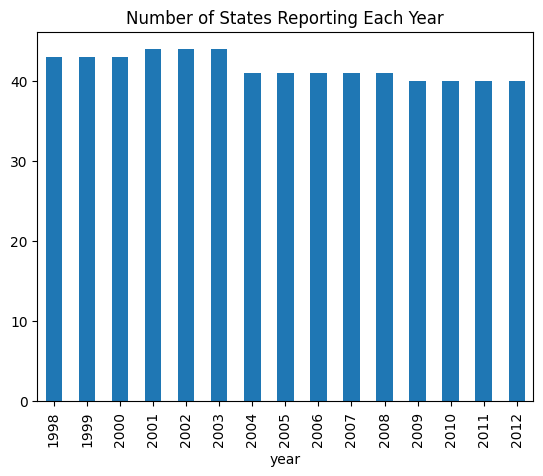

In [14]:

# Load raw data
honey_raw = pd.read_csv('honeyproduction.csv')

def assess_dataset(df):
    print("=== Dataset Shape ===")
    print(df.shape)
    
    print("\n=== Data Types ===")
    print(df.dtypes)
    
    print("\n=== Missing Values ===")
    print(df.isnull().sum())
    
    print("\n=== Descriptive Statistics ===")
    print(df.describe())
    
    print("\n=== Duplicate Rows ===")
    print(f"Total duplicates: {df.duplicated().sum()}")
    

assess_dataset(honey_raw)

# State coverage analysis
print("\n=== State Coverage Over Time ===")
state_coverage = honey_raw.groupby('year')['state'].nunique()
state_coverage.plot(kind='bar', title='Number of States Reporting Each Year')
plt.show()

In [ ]:
# Data Cleaning
class HoneyDataCleaner:
    def __init__(self, df):
        self.df = df.copy()
        
    def clean_column_names(self):
        """Standardize column names"""
        self.df.columns = self.df.columns.str.lower().str.replace(' ', '_')
        return self
        
    def handle_missing_values(self):
        """Address missing values appropriately"""
        # For production metrics, fill with 0 if missing
        prod_cols = ['numcol', 'yieldpercol', 'totalprod', 'stocks']
        self.df[prod_cols] = self.df[prod_cols].fillna(0)
        
        # For price data, use median by year
        self.df['priceperlb'] = self.df.groupby('year')['priceperlb'].transform(
            lambda x: x.fillna(x.median()))
        
        return self
        
    def validate_production(self):
        # Calculate expected totalprod and compare with reported
        self.df['calculated_prod'] = self.df['numcol'] * self.df['yieldpercol']
        self.df['prod_discrepancy'] = self.df['totalprod'] - self.df['calculated_prod']
        
        # Flag large discrepancies (> 10% difference)
        threshold = 0.1 * self.df['totalprod']
        self.df['prod_flag'] = np.where(
            abs(self.df['prod_discrepancy']) > threshold, 1, 0)
        
        return self
        
    def clean_state_names(self):
        self.df['state'] = self.df['state'].str.title().str.strip()
        return self
        
    def get_clean_data(self):
        return self.df


In [18]:

# Load cleaned data
honey_clean = pd.read_csv('honeyproduction.csv')

# 1. Time-based features
honey_clean['ccd_era'] = np.where(honey_clean['year'] >= 2006, 'Post-CCD', 'Pre-CCD')

# 2. Production efficiency metrics
honey_clean['prod_efficiency'] = honey_clean['totalprod'] / (honey_clean['numcol'] + 1)
honey_clean['value_per_colony'] = honey_clean['prodvalue'] / (honey_clean['numcol'] + 1)

# 3. Year-over-year changes by state
honey_clean = honey_clean.sort_values(['state', 'year'])
for col in ['numcol', 'totalprod', 'prodvalue']:
    honey_clean[f'{col}_yoy_pct'] = (honey_clean.groupby('state')[col].pct_change() * 100)

# 4. Market indicators
honey_clean['stock_ratio'] = honey_clean['stocks'] / (honey_clean['totalprod'] + 1)
honey_clean['price_volatility'] = honey_clean.groupby('state')['priceperlb'].transform(
    lambda x: x.rolling(3).std())

# 5. Regional aggregations
state_regions = {
    'California': 'West',
    'Montana': 'West',
    # ... add all states
}
honey_clean['region'] = honey_clean['state'].map(state_regions)

# Save enhanced dataset
honey_clean.to_csv('honey_enhanced.csv', index=False)